# Unsupervised Methods

In [1]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import multiprocessing
from sklearn.cluster import KMeans
from scipy.sparse import dok_matrix


## Trying to use Word2Vec

Confused on this for now, there is a "manual" method below.

In [47]:
cores = multiprocessing.cpu_count()

In [48]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=1000,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [3]:
data = pd.read_csv('../data/labelled_phrases.csv')
data.head()

,phrase_id,phrase_tokens,sentiment_value,sentiment
0,3,['cockettes'],0.50000,neutral
1,4,['cockettes'],0.42708,neutral
2,5,"['cockettes', 'provide', 'window', 'subculture...",0.37500,negative
3,6,"['cockettes', 'provide', 'window', 'subculture...",0.41667,neutral
4,7,"['cockettes', 'provide', 'window', 'subculture...",0.54167,neutral


In [50]:
data['phrase_lists'] = data['phrase_tokens'].apply(lambda x: x.split())

In [51]:
w2v_model.build_vocab(data['phrase_lists'], progress_per=10000)

In [52]:
w2v_model.train(data['phrase_lists'], total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

(2807409, 5149095)

In [53]:
wordvecs = w2v_model.wv

In [54]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(wordvecs.vectors)

In [55]:
wordvecs.similar_by_vector(kmeans.cluster_centers_[1], topn=20)

[("['pay']", 0.14025120437145233),
 ("['find']", 0.13390228152275085),
 ("['enjoy']", 0.13276638090610504),
 ("['sequel']", 0.1322898268699646),
 ("['u']", 0.12780815362930298),
 ("['plot']", 0.12619267404079437),
 ("['compelling']", 0.12338240444660187),
 ("['audience']", 0.12305498868227005),
 ("['likely']", 0.12161680310964584),
 ("['mark']", 0.12137159705162048),
 ("['sort']", 0.12096580117940903),
 ("['great']", 0.12036927789449692),
 ("['man']", 0.11720839142799377),
 ("['need']", 0.11563523858785629),
 ("['script']", 0.1155271828174591),
 ("['original']", 0.11514805257320404),
 ("['part']", 0.11510933935642242),
 ("['moment']", 0.11435109376907349),
 ("['release']", 0.11370164155960083),
 ("['grow']", 0.11044472455978394)]

In [5]:
vocab = list(set(data['phrase_tokens'].str.cat(sep=' ').split()))
word2id = {vocab[x] :x for x in range(len(vocab))}

In [57]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

## Manual Method not using Word2Vec

In [6]:
def convert_to_matrix(data, word2id):
    mat_size = len(data),len(word2id)+1
    oov_index = len(word2id)
    
    X = dok_matrix(mat_size)
    
    for doc_id, doc in enumerate(list(data['phrase_tokens'])):
        for word in doc.split():
            X[doc_id,word2id.get(word, oov_index)] += 1
    
    return X

X = convert_to_matrix(data, word2id)

In [59]:
k = KMeans(n_clusters=2)

In [60]:
k.fit(X)

KMeans(n_clusters=2)

In [61]:
for x in np.argsort(k.cluster_centers_[1])[-20:]:
    print(vocab[x])

'one']
'even',
'would',
'film']
['not',
'enough',
'idea',
'character',
'time',
'movie']
'one',
'time']
'bad',
'make',
'feel',
'not',
'n',
'film',
'movie',
'good',


In [62]:
for x in np.argsort(k.cluster_centers_[0])[-20:]:
    print(vocab[x])

['make',
'no',
['n',
['not',
'even',
'much',
'time',
['film',
'well',
'story',
'character',
'one',
'film']
'movie']
'not',
'like',
'make',
'n',
'film',
'movie',


In [63]:
sentiment_simple = data['sentiment_value'] < 0.5

In [64]:
sentiment_simple = sentiment_simple.astype(int)

In [65]:
np.unique(sentiment_simple, return_counts=True)

(array([0, 1]), array([149846,  87598]))

In [66]:
np.unique(k.labels_, return_counts=True)

(array([0, 1], dtype=int32), array([234636,   2808]))

In [67]:
scores = np.unique(k.labels_ == sentiment_simple, return_counts=True)

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

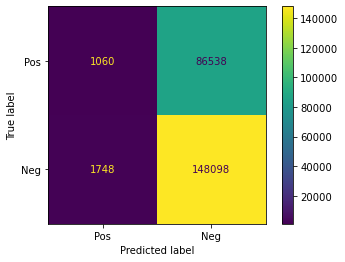

In [69]:
y_true = sentiment_simple
y_preds = k.labels_
cm = confusion_matrix(y_true, y_preds, labels=[1, 0])
disp = ConfusionMatrixDisplay(cm, display_labels=['Pos', 'Neg'])
disp.plot()

In [70]:
scores[1][1] / sum(scores[1])

0.6281818028672024

In [71]:
f1_score(y_true, y_preds, average='weighted')

0.494819957633275

## Setup

In [1]:
# Put some stuff here to reduce the clutter
import numpy as np
import pandas as pd
from scipy.sparse import dok_matrix

data = pd.read_csv('../data/labelled_phrases.csv')
data['phrase_lists'] = data['phrase_tokens'].apply(lambda x: x.split())
vocab = list(set(data['phrase_tokens'].str.cat(sep=' ').split()))
word2id = {vocab[x] :x for x in range(len(vocab))}

In [2]:
def convert_to_matrix(data, word2id):
    mat_size = len(data),len(word2id)+1
    oov_index = len(word2id)
    
    X = dok_matrix(mat_size)
    
    for doc_id, doc in enumerate(list(data['phrase_tokens'])):
        for word in doc.split():
            X[doc_id,word2id.get(word, oov_index)] += 1
    
    return X

X = convert_to_matrix(data, word2id)

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

sentiment_simple = data['sentiment_value'] < 0.5
sentiment_simple = sentiment_simple.astype(int)
y_true = sentiment_simple
np.unique(sentiment_simple, return_counts=True)

(array([0, 1]), array([149846,  87598]))

## Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

# Takes very long
spectral_clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors').fit(X)

/home/db/miniconda3/envs/dme/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [ ]:
np.unique(spectral_clustering.labels_, return_counts=True)

In [ ]:
spectral_scores = np.unique(spectral_clustering.labels_ == sentiment_simple, return_counts=True)

y_preds = spectral_clustering.labels_
cm = confusion_matrix(y_true, y_preds, labels=[1, 0])
disp = ConfusionMatrixDisplay(cm, display_labels=['Pos', 'Neg'])
disp.plot()

In [ ]:
spectral_scores[1][1] / sum(spectral_scores[1])

In [ ]:
f1_score(y_true, y_preds, average='weighted')

## Birch Clustering

In [ ]:
from sklearn.mixture import Birch

birch = Birch(n_cluster=2).fit(X)

In [ ]:
np.unique(birch.labels_, return_counts=True)

In [ ]:
birch_scores = np.unique(birch.labels_ == sentiment_simple, return_counts=True)

y_preds = birch.labels_
cm = confusion_matrix(y_true, y_preds, labels=[1, 0])
disp = ConfusionMatrixDisplay(cm, display_labels=['Pos', 'Neg'])
disp.plot()

In [ ]:
birch_scores[1][1] / sum(birch_scores[1])

In [5]:
f1_score(y_true, y_preds, average='weighted')

NameError: name 'y_preds' is not defined